In [1]:
from IPython.display import Image
from keras.layers import Dense
from keras.layers import Dropout
from keras.models import Sequential
from keras.utils import to_categorical
from skimage.transform import resize
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import h5py
%matplotlib inline

Using TensorFlow backend.


In [2]:
DATA_LOCATION = '../data/'
TRAIN_IMAGES_LOCATION = '../data/train_images/'
IMAGE_SIZE = 64

In [3]:
train_labels = pd.read_csv(DATA_LOCATION + 'train_onelabel.csv')
train_labels = train_labels.rename(columns={'image': 'filepath'})
#train_labels = train_labels.sample(n=2000)

In [4]:
def get_image(row):
    """
    Load image from filepath to a numpy.ndarray
    input:
        - filepath: string with relative or absolute path to image
    output:
        - img:
            numpy.ndarray containing the image
            shaped (M,N), values [0.0, 1.0]
    """
    try:
        img = TRAIN_IMAGES_LOCATION + row['filepath']
        img = mpimg.imread(img)
    except:
        img = row
        img = mpimg.imread(img)
    img = np.absolute(np.divide(img.astype(float), 255) - 1.0)
    return img

def get_padding(i):
    """
    Helper function for getting right padding sizes
    input:
        - i: positive integer gotten from substracting height and width of an image
    output:
        - Tuple representing the correct padding
    """
    if i%2 == 0:
        return (int(i/2),int(i/2))
    else:
        return (int(i/2-.5), int(i/2+.5))
    
def pad_image(img):
    """
    Add padding to image to make it square
    input:
        - img: numpy array (2D) representing image
    output:
        - padded array of shape (N,N)
    """
    H, W = img.shape
    if H == W:
        return img
    elif H > W:
        return np.pad(img, ((0,0), get_padding(H-W)), 'constant')
    else:
        return np.pad(img, (get_padding(W-H), (0,0)), 'constant')
    
def resize_image(img, size):
    """
    Resize image to new square shape
    input:
        - img: numpy array (2D) representing image
        - size: final shape of image in pixels (integer)
    """
    return resize(img, (size,size), mode='reflect')

def flattened_image(row):
    """
    Loads and processes image to be used later on
    input:
        - row: Pandas.DataFrame row
    output:
        - Python list, flattened np.ndarray
    """
    img = get_image(row)
    img = pad_image(img)
    img = resize_image(img, IMAGE_SIZE)
    return img.flatten().tolist()

def get_shape(row):
    """
    Loads and processes image to be used later on
    input:
        - row: Pandas.DataFrame row
    output:
        - tuple, with original image dimensions
    """
    img = get_image(row)
    return img.shape

In [5]:
# get image from file
# pad the image to a sqaure
# resize to IMAGE_SIZE
# flatten and convert np.array to Python list
train_labels['image'] = train_labels.apply(flattened_image, axis=1)

In [6]:
train_labels.sample(n=10)

,filepath,class,image
13927,99403.jpg,61,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
23527,87866.jpg,117,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
19291,115349.jpg,99,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
18872,130360.jpg,95,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
12187,22280.jpg,58,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
16664,71220.jpg,84,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
21802,34607.jpg,105,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
8172,99043.jpg,34,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
495,109124.jpg,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
10753,114425.jpg,49,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


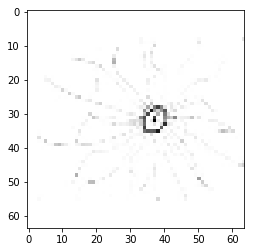

In [7]:
example = train_labels.sample(n=1).iloc[0]['image']
plt.imshow(np.asarray(example).reshape(IMAGE_SIZE,IMAGE_SIZE),cmap='binary')

In [8]:
# Change the labels from integer to categorical data
train_labels_one_hot = to_categorical(train_labels['class'])
# Find the unique numbers from the train labels
classes = np.unique(train_labels['class'])
nClasses = len(classes)

In [9]:
train_data = train_labels['image'].values

In [10]:
for i in range(len(train_data)):
    train_data[i] = np.asarray(train_data[i])

print('{}, {}'.format(train_data.shape, train_data[0].shape))
train_data = np.array(train_data.tolist())
print('{}'.format(train_data.shape))

(24204,), (4096,)
(24204, 4096)


In [12]:
model_reg = Sequential()
model_reg.add(Dense(512, activation='relu', input_shape=(IMAGE_SIZE**2,)))
model_reg.add(Dropout(0.5))
model_reg.add(Dense(512, activation='relu'))
model_reg.add(Dropout(0.5))
model_reg.add(Dense(nClasses, activation='softmax'))

model_reg.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

history_reg = model_reg.fit(train_data, train_labels_one_hot, batch_size=256, epochs=20, verbose=1)

Epoch 1/20
24204/24204 [==============================] - 17s - loss: 3.5298 - acc: 0.2129    
Epoch 2/20
24204/24204 [==============================] - 14s - loss: 2.8351 - acc: 0.3193    
Epoch 3/20
24204/24204 [==============================] - 14s - loss: 2.5027 - acc: 0.3773    
Epoch 4/20
24204/24204 [==============================] - 15s - loss: 2.2880 - acc: 0.4097    
Epoch 5/20
24204/24204 [==============================] - 14s - loss: 2.1467 - acc: 0.4359    
Epoch 6/20
24204/24204 [==============================] - 15s - loss: 2.0256 - acc: 0.4591    
Epoch 7/20
24204/24204 [==============================] - 16s - loss: 1.9291 - acc: 0.4773    
Epoch 8/20
24204/24204 [==============================] - 17s - loss: 1.8496 - acc: 0.4934    - ETA: 1s - loss: 1.8469 - acc:
Epoch 9/20
24204/24204 [==============================] - 17s - loss: 1.7808 - acc: 0.5094    
Epoch 10/20
24204/24204 [==============================] - 15s - loss: 1.7156 - acc: 0.5165    
Epoch 11/20
24204/

In [13]:
model_reg.save('../data/output/models/model1.h5')